In [22]:
from __future__ import print_function
import numpy as np
from sklearn.utils import shuffle
from sklearn import metrics
import matplotlib.pyplot as plt
from model_function import *
from random import seed
import pandas as pd
import time
import sys
import warnings
import math
import os
import random
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.init as init
from torch.autograd import Variable
import torch.utils.data as Data
from sklearn.model_selection import train_test_split
import pandas as pd
import csv

random.seed(222)

data = pd.read_csv("real_data_preprocessing/Mouse/processed/data.csv")
sample_id = data.columns.values[5:data.shape[1]]
sample_id[455] = '498307_CSH_LA_M6_PO'
X = (data.iloc[:,5:data.shape[1]]).values
X = X.T

m_min = np.min(X, 0)
m_max = np.max(X, 0)

X = np.log(1+X)

expression = ((X - m_min)/(m_max - m_min)-0.5) * 100

feature_meta = pd.read_csv("real_data_preprocessing/Mouse/processed/feature_meta_matching.csv")

data = pd.read_csv("real_data_preprocessing/Mouse/processed/data.csv")
mode = ['pos_' if 'pos' in i else 'neg_' for i in data['Unnamed: 0']]
feature_name = [mode[i]+str(round(data['mz'][i],3)) for i in range(len(data['mz']))]

c_name = (feature_meta.columns).values[1:]
feature_meta = feature_meta.values[:,1:]
feature_meta.shape

# compound adj matrix
partition = (pd.read_csv("real_data_preprocessing/Mouse/processed/adj_mtx.csv")).values[:,1:]
partition.shape

# assign the diag to be 1
np.fill_diagonal(partition, 1)

sample_id = np.array([i.replace('.mzML','') for i in sample_id])
sample_id = np.array([i.replace('_02','') for i in sample_id])
sample_id = np.array([i.replace('_002','') for i in sample_id])
area = np.array([i[17:19] for i in sample_id])
age = np.array([i[11:13] for i in sample_id])
import collections
area_summary = collections.Counter(area)

age_summary = collections.Counter(age)
print(age_summary)

choose_idx = np.arange(len(age))
choose_age = age[choose_idx]

no_area = 'AD'

drop_idx = np.where(choose_age == no_area)[0]
choose_age = np.delete(choose_age, drop_idx)
choose_idx = np.delete(choose_idx, drop_idx)

expression = X[choose_idx,:]

y = np.zeros([len(choose_idx)])

ion_matrix = pd.read_csv("real_data_preprocessing/Mouse/processed/ion_matching.csv")
ion_matrix = ion_matrix.values[:,1:]

# AD young; EA adult; LA elder;

y[np.where(choose_age=='LA')] = 1
target = y.astype(int)

brain_list = np.unique(area)
brain_idx = np.array([np.where(brain_list == i)[0][0] for i in area])
area_matrix = np.zeros([len(area), 10])
area_matrix[np.arange(len(area)), brain_idx] = 1
area_matrix = area_matrix[choose_idx,:]

x_train, x_val, y_train, y_val, area_train, area_val = train_test_split(
         expression, target, area_matrix, test_size = 0.2,random_state = 6)

Counter({'AD': 160, 'EA': 160, 'LA': 160})


In [14]:
sparsify_coefficient = 0.3  #0.2
threshold_layer_size = 100
num_hidden_layer_neuron_list = [20]  # if assigning a null list. it means directly predicting (sparsifying results to two-neuron output layer) (default)
sparsify_hidden_layer_size_dict = getLayerSizeList(partition, threshold_layer_size, sparsify_coefficient)
degree_dict = getNodeDegreeDict(partition)
partition_mtx_dict = getPartitionMatricesList(sparsify_hidden_layer_size_dict, degree_dict, feature_meta, partition)

In [20]:
class Net(nn.Module):
    def __init__(self,partition_mtx_dict, num_hidden_layer_neuron_list, keep_prob):
        super(Net,self).__init__()
        layer1 = nn.Sequential()
        for i in range(len(partition_mtx_dict)):
            mtx = partition_mtx_dict["p%d" % i]  # the mask matrix
            layer1.add_module('f'+ str(i), SparseLinear(mtx.shape[0], mtx.shape[1], mtx))
            layer1.add_module("f_relu"+str(i), nn.ReLU(True))
            layer1.add_module("bn1"+str(i), nn.BatchNorm1d(mtx.shape[1]))
        self.layer1 = layer1
        
        layer2 = nn.Sequential()
        num_hidden_layer_neuron_list = [mtx.shape[1] + 10] + num_hidden_layer_neuron_list + [2]  # add 10 to identify different area
        for j in range(1, len(num_hidden_layer_neuron_list)-1):
            layer2.add_module('h'+str(j), myLinear(num_hidden_layer_neuron_list[j-1], num_hidden_layer_neuron_list[j]))
            layer2.add_module('h_relu'+str(j), nn.ReLU(True))
            layer2.add_module("bn2"+str(j), nn.BatchNorm1d(num_hidden_layer_neuron_list[j]))
            layer2.add_module('h_drop'+str(j), nn.Dropout(p=keep_prob))
        layer2.add_module('h'+str(j+1), myLinear(num_hidden_layer_neuron_list[j], num_hidden_layer_neuron_list[j+1]))
        self.layer2 = layer2
        
    def forward(self,input,area_info):
        out = self.layer1(input)
        out = torch.cat((out, area_info),-1)  # here we consider ten different brain area, thus use 10 more nodes to represent various areas
        out = self.layer2(out)
        return out

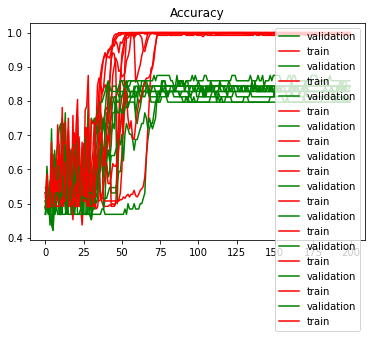

In [24]:
import csv

s = [3,9,11,12,15,18,27,28,30,37] # new seed

for i in range(10):
    file_name = "mouse_"+str(i)+'_.pkl'

    seed = s[i]
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    keep_prob = 0.3
    net = Net(partition_mtx_dict, num_hidden_layer_neuron_list, keep_prob)

    BATCH_SIZE = 64

    warnings.filterwarnings("ignore", category=UserWarning)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.1, weight_decay = 0.001)  # # lr = 0.1 # wd = 0.1

    loss_func = torch.nn.CrossEntropyLoss()

    x = (torch.from_numpy(x_train)).type(torch.FloatTensor)
    y = (torch.from_numpy(y_train)).type(torch.LongTensor)
    z = (torch.from_numpy(area_train)).type(torch.FloatTensor)

    torch_dataset = Data.TensorDataset(x, y, z)

    loader = Data.DataLoader(
        dataset=torch_dataset,     
        batch_size=BATCH_SIZE,     
        shuffle=True,              
        num_workers=0           
    )

    x = Variable(x)
    y = Variable(y)
    z = Variable(z)

    acc_train = []
    acc_val = []
    acc_val_i = 0
    accuracy = 0
    best_test = 0
    corr_train = 0
    for epoch in range(200): 
        if ((acc_val_i >0.9) &(accuracy>0.9)):
            break
        net.train()
        if epoch<20:
            optimizer.param_groups[0]['lr'] *= 0.97
        if epoch >20:
            optimizer.param_groups[0]['lr'] *= 0.9

        for step, (x_batch, y_batch, z_batch) in enumerate(loader): 
            x_batch = x_batch
            y_batch = y_batch
            z_batch = z_batch
            optimizer.zero_grad()
            prediction = net(x_batch, z_batch)
            loss = loss_func(prediction,y_batch)

            loss.backward()

            optimizer.step()

        with torch.no_grad():
            net.eval()
            prediction = net(x,z)
            pred_y = prediction.data.numpy().squeeze()
            target_y = y.cpu().data.numpy()
            
            accuracy = sum(target_y ==np.argmax(pred_y, axis=1))/len(target_y)  # 预测中有多少和真实值一样
            acc_train.append(accuracy)

            val_input_tensor = (torch.from_numpy(x_val)).type(torch.FloatTensor)
            val_input_tensor_z = (torch.from_numpy(area_val)).type(torch.FloatTensor)
            out_probs = net(val_input_tensor, val_input_tensor_z).data.numpy().squeeze()
            out_classes = np.argmax(out_probs, axis=1)
            acc_val_i = sum(out_classes == y_val) / len(y_val)
            acc_val.append(sum(out_classes == y_val) / len(y_val))
            if acc_val_i > best_test:
                best_test = acc_val_i
                corr_train = accuracy
                torch.save(net, file_name) 

    plt.plot(acc_val, color = "green", label = "validation")
    plt.plot(acc_train, color = "red", label = "train")
    plt.legend()
    plt.title("Accuracy")

    file_name = "mouse_accuracy.csv"
    if not(os.path.exists(file_name)):
        with open(file_name,"a") as csvfile:
            writer = csv.writer(csvfile)
    with open((file_name),"a") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(list([corr_train, best_test]))

In [23]:
for i in range(10):
    net = torch.load("mouse_"+str(i)+'_.pkl')
    params = []
    for parameters in net.parameters():
        params.append(parameters.cpu().detach().numpy())

    h0 = params[0].T
    h1 = params[4].T
    h2 = params[8].T

    meta_left = abs(h1).sum(axis = 0)
    meta_right = abs(h2).sum(axis = 1)

    meta_imp = meta_right/meta_right.sum() + meta_left/meta_left.sum()

    degree = np.sum(partition,0)+1
    count_feature = np.sum(feature_meta, 0)+1
    f_left = np.sum(abs(h0),0)/(count_feature**0.5)
    f_right = np.sum(abs(h1),1)/(degree**0.5)
    f_imp = (f_left/f_left.sum()) + (f_right/f_right.sum())

    dat = {'imp': list(f_imp),
          'name': list(c_name)}
    df = pd.DataFrame(dat)

    n_feature = len(feature_name)

    max_idx = np.argmax(abs(h0) / f_imp / meta_imp, axis=1)
    Link = abs(h0)/f_imp/meta_imp

    h0_new = np.zeros(h0.shape)
    h0_new[range(n_feature), max_idx] = h0[range(n_feature), max_idx]
    h0_new[h0_new!=0] = 1
    feature_imp = np.dot(h0_new, f_imp)

    file_name = "mouse_meta_imp.csv"
    if not(os.path.exists(file_name)):
        with open(file_name,"a") as csvfile:
            writer = csv.writer(csvfile)
    with open((file_name),"a") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(list(f_imp))

    file_name = "mouse_feature_imp.csv"
    if not(os.path.exists(file_name)):
        with open(file_name,"a") as csvfile:
            writer = csv.writer(csvfile)
    with open((file_name),"a") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(list(feature_imp))

    file_name = "mouse_link.txt"
    if not(os.path.exists(file_name)):
        np.savetxt("mouse_link.txt",Link)
    else:
        old=np.loadtxt("mouse_link.txt", delimiter=' ')
        new = old + Link
        np.savetxt("mouse_link.txt",Link)

In [ ]:
file_name = "mouse_meta_imp.csv"
meta_total = pd.read_csv(file_name,header = None)
meta_avg = np.mean(meta_total.values, axis = 0)
f_imp = meta_avg

file_name = "mouse_feature_imp.csv"
feature_total = pd.read_csv(file_name,header = None)
feature_avg = np.mean(feature_total.values, axis = 0)
feature_imp = feature_avg

Link = np.loadtxt("mouse_link.txt", delimiter=' ')

dat = {'imp': list(f_imp),
      'name': list(c_name)}
df = pd.DataFrame(dat)

In [26]:
import rpy2.robjects as ro
import rpy2.robjects as robjects
import rpy2.robjects
import rpy2.robjects.numpy2ri

rpy2.robjects.numpy2ri.activate()

ro.r.assign("x", f_imp)

rpy2.robjects.numpy2ri.activate()
robjects.r(
           '''
            fdrgamma<-function(x, use.percentile=NA, min.use.percentile=0.5)
            {
             library(MASS)

             x0<-x
             if(length(x)>50000) x<-sample(x, 50000, replace=F)

             all.use.percentile<-use.percentile
             if(is.na(use.percentile)) all.use.percentile<-seq(min.use.percentile,0.99,by=0.01)

             d.x<-density(x,from=0)
             x.mode<-d.x$x[which(d.x$y==max(d.x$y))[1]]
             rec<-rep(0, length(all.use.percentile))

             for(i in 1:length(all.use.percentile))
             {
              use.percentile<-all.use.percentile[i]
              params<-fitdistr(x[x<quantile(x,use.percentile)],"gamma")

              d.x.lim<-density(x,from=0,to=quantile(x,use.percentile))
              d.null.lim<-dgamma(d.x.lim$x, shape=params$estimate[1], rate=params$estimate[2])*use.percentile
              sel<-which(d.x.lim$x <= x.mode)
              rec[i]<-sum((d.x.lim$y[sel]-d.null.lim[sel])^2)

             }

             sel<-which(rec==min(rec))[1]
             use.percentile=all.use.percentile[sel]
             cat('null %', use.percentile, "; ")

             d.x<-density(x,from=0, n=min(512, length(x)/2))
             params<-fitdistr(x[x<quantile(x,use.percentile)],"gamma")
             d.null<-dgamma(d.x$x, shape=params$estimate[1], rate=params$estimate[2])

             null.mode.x<-d.x$x[which(d.null==max(d.null))[1]]

             #plot(d.x, type="l")
             hist(x,nclass=min(round(length(x)/10),100),freq=FALSE)
             lines(d.x$x, d.null*use.percentile,col="red")
             lines(d.x, col="blue")

             lfdr<-d.null/d.x$y*use.percentile
             lfdr[lfdr>1]<-1
             lfdr[is.na(lfdr)]<-1
             lfdr[d.x$x<=null.mode.x]<-1
             sel<-which(lfdr==max(lfdr))[1]
             lfdr[1:sel]<-max(lfdr)
             lfdr<-cummin(lfdr)

             all.lfdr<-approx(d.x$x, lfdr, x0, rule=2)

             #cut<-min(which(d.x$x>median(x) & lfdr<=fdr.cut))
             #xcut<-d.x$x[cut]
             #if(is.na(xcut)) xcut<-Inf
             #abline(v=xcut, col="blue")
             return(all.lfdr[[2]])
            }
            
            res = fdrgamma(x, use.percentile=0.75)
           '''
           )
fdr = robjects.r['res']

null % 0.75 ; 

The number of selected metbaolites 41


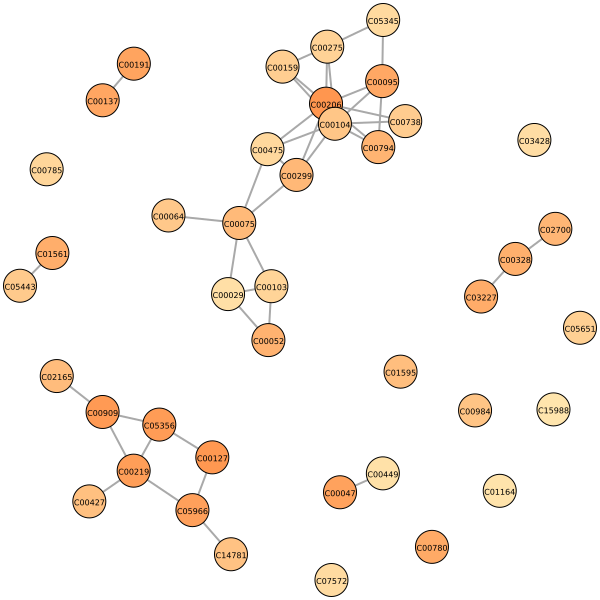

In [30]:
thres = sum(fdr<0.05)
print('The number of selected metbaolites %d' %thres)

sel_idx = np.argsort(-f_imp)[0:thres]
sel_name = c_name[sel_idx]
sel_name

import igraph

np.fill_diagonal(partition, 0) # change the diag of partition

g_sub = igraph.Graph.Adjacency((partition[sel_idx,:][:,sel_idx] > 0).tolist(), mode = "undirected")

g_sub.vs["size"] = 33
g_sub.vs['label'] = sel_name
g_sub.vs["label_size"] = 8

palette = igraph.drawing.colors.AdvancedGradientPalette(['#ff964f','#ffe5ad'], n=len(sel_idx))

g_sub.vs["color"]= palette
g_sub.es['color'] = "darkgrey"
g_sub.es['size'] = 0.1
g_sub.es['width'] = 2

igraph.plot(g_sub)

In [32]:
############# use part of r code ###########
import rpy2.robjects as ro
import rpy2.robjects as robjects
import rpy2.robjects
import rpy2.robjects.numpy2ri
from rpy2.robjects.lib.dplyr import DataFrame
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

rpy2.robjects.numpy2ri.activate()

ro.r.assign("imp", df.iloc[:,0].values)
ro.r.assign("name", df.iloc[:,1].values)
ro.r.assign("thres", thres)

rpy2.robjects.numpy2ri.activate()
robjects.r(
           '''
            library(metapone)
            data(pa)
            idx <- order(imp,decreasing=TRUE)[1:thres]

            pathway_name_100 <- c()
            for (i in 1:thres) {
              p <- pa[which(pa$KEGG.ID==name[idx[i]]),2]
              pathway_name_100 <- c(pathway_name_100, p)
            }

            meta_name_sub = name
            meta_name_100 = name[idx]

            # pathway related to the top 100 compound
            pathway_name_100 = unique(pathway_name_100)

            df = as.data.frame(matrix(nrow=0,ncol=5))
            for (n in pathway_name_100) {
              c = pa[which(pa$pathway.name==n),4]
              in_100 = sum(c %in% meta_name_100)
              in_sub = sum(c %in% meta_name_sub)
              in_100_name = paste(c[c %in% meta_name_100],collapse=",")
              in_sub_name = paste(c[c %in% meta_name_sub],collapse=",")
              p_value = 1.0-phyper(in_100-1, thres, length(imp)-thres, in_sub)
              df <- rbind(df, c(n, in_100_name, in_sub_name, p_value, paste(c[c %in% meta_name_100],collapse=",")))
            }

            names(df) <- c("pathway",  "num_in_selected", "num_in_all", "p_value", "compound id")
           '''
           )

res = robjects.r['df']

go_res = pd.DataFrame(res)
go_res['p_value'] = (go_res['p_value']).astype('float')
go_res.sort_values("p_value",inplace=True)
go_res.reset_index(drop=True,inplace = True)
go_res.to_csv('mouse_go_restult.csv')